In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img, (224, 224, 1)))

    flows = []
    for i in range(0, len(video) - 1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i + 1], None, 0.5, 3, 15, 3, 5, 1.2,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
        # Add into list
        flows.append(flow)

    # Padding the last frame as empty array
    flows.append(np.zeros((224, 224, 2)))

    return np.array(flows, dtype=np.float32)


def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()

    # Get the optical flow of video
    flows = getOpticalFlow(frames)

    # Visualize optical flow map
    farneback_visual(flows)

    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows

    return result

def farneback_visual(flows):
    pass


def Save2Npy(file_dir, save_dir):   # modify this code to save the npy files for your directory or path
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src
        video_path = os.path.join(file_dir, v)
        # Get dest
        save_path = os.path.join(save_dir, video_name+'.npy')
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)

    return None

In [ ]:
source_path = '/content/drive/MyDrive/raw_video'
target_path = '/content/drive/MyDrive/data_npy'

for f1 in ['train', 'val']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

In [ ]:
source_path = '/content/drive/MyDrive/raw_video'
target_path = '/content/drive/MyDrive/data_npy'

for f1 in ['test']:
    for f2 in ['Fight', 'NonFight']:
        path1 = os.path.join(source_path, f1, f2)
        path2 = os.path.join(target_path, f1, f2)
        Save2Npy(file_dir=path1, save_dir=path2)

In [ ]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import wandb
import random
from sklearn.metrics import roc_auc_score, recall_score
import argparse
import torch.nn.functional as F
import uuid


class DataGenerator(Dataset):

    ### basic function templates for Dataset class in Pytorch : __init__, __len__, __getitem__###
    def __init__(self, directory, data_augmentation=False, phase='train'):
        self.phase=phase #for what?
        self.directory = directory
        self.data_aug = data_augmentation
        self.X_path, self.Y_dict = self.search_data()
        self.print_stats()

    def __len__(self):
        steps_per_epoch = int(len(self.X_path))
        return steps_per_epoch

    # get data and label corresponding to index using 'data_generation function'
    def __getitem__(self, index):
        # print("getitem")
        data, label = self.data_generation(self.X_path[index])
        return data.float(), label

    #############################################################
    # -----------------codes down from this line are provided.------------------- #
    # call raw data using data path, and data processing including 'uniform sampling', 'color jittering', 'random flip', and 'normalize'
    #############################################################

    def load_data(self, path):
        data = np.load(path, mmap_mode='r', allow_pickle= True) # Read the raw data from path
        data = self.uniform_sampling(data, target_frames=64) # Randomly sample number of target frames
        if self.data_aug: # If data is augmented...
            data[..., :3] = self.color_jitter(data[..., :3])
            data = self.random_flip(data, prob=0.5) # Random flip image into random direction
        data[..., :3] = self.normalize(data[..., :3]) # Normalize RGB
        data[..., 3:] = self.normalize(data[..., 3:]) # Normalize optical flows
        return data

    # Normalize data
    def normalize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std


    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(video, (2,)) # Flip in width direction
        return video

    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])
        # calculate numer of padded frames and fix it
        num_pad = target_frames - len(sampled_video) # num pad = # target frame - # current frame
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try:
                    padding.append(video[i]) # Fill with the last video frame
                except:
                    padding.append(video[0])
            sampled_video += padding # Add padding results
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)

    # Jitter = spread values
    def color_jitter(self, video):
        s_jitter = np.random.uniform(-0.2, 0.2)
        v_jitter = np.random.uniform(-30, 30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(np.array(video[i]), cv2.COLOR_RGB2HSV) # Convert RGB -> HSV
            s = hsv[..., 1] + s_jitter # saturation jitter
            v = hsv[..., 2] + v_jitter # Value jitter
            # Flip
            s[s < 0] = 0
            s[s > 1] = 1
            v[v < 0] = 0
            v[v > 255] = 255
            hsv[..., 1] = s # set jittered saturation
            hsv[..., 2] = v # Set jittered value
            video[i] = torch.Tensor(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)) # Convert HSV -> RGB again
        return video

    # print current state sof the Dataset class
    def print_stats(self):
            self.n_files = len(self.X_path)
            self.n_classes = len(self.dirs)
            self.indexes = np.arange(len(self.X_path))
            np.random.shuffle(self.indexes)
            print("Found {} files belonging to {} classes.".format(self.n_files, self.n_classes))
            for i, label in enumerate(self.dirs):
                print('{:10s} : {}'.format(label, i))

    # get data and label(one-hot encoded) from path list/dictionary
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory)) # Get sorted file directories fight / non-fight
        #for the folder(dic), we assign one hot encoding
        label_dict = {folder: i for i, folder in enumerate(self.dirs)}

        for i, folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory, folder)  # folder_path = ...train/Fight or ...train/NonFight
            for file in os.listdir(folder_path):
                path = os.path.join(folder_path,file)
                X_path.append(path)
                Y_dict[path] = label_dict[folder]
                # Assign one hot encoded vector into Y_dict

        return X_path, Y_dict

    # define batch x using 'load_data' function and batch_y from self.Y_dict.
    def data_generation(self, batch_path):
        batch_x = self.load_data(batch_path)  # 동영상 데이터를 처리
        batch_y = self.Y_dict[batch_path]

        # Transfer numpy array to tensor
        batch_x = torch.tensor(batch_x.copy())
        batch_y = torch.tensor(batch_y, dtype=torch.long)

        return batch_x, batch_y

#Model Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.relu=nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.maxpool_channel = nn.MaxPool3d(kernel_size = (1,2,2))
        self.maxpool_merge = nn.MaxPool3d(kernel_size = (2,2,2))

        self.layer_RGB = nn.Sequential(
            #layer1
            nn.Conv3d(3, 16, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)), #spatial convolution
            self.relu,
            nn.Conv3d(16, 16, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)), #temporal convolution
            self.relu,
            self.maxpool_channel,

            #layer2
            nn.Conv3d(16, 16, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.relu,
            nn.Conv3d(16, 16, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_channel,

            #layer3
            nn.Conv3d(16, 32, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.relu,
            nn.Conv3d(32, 32, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_channel,

            #layer4
            nn.Conv3d(32, 32, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.relu,
            nn.Conv3d(32, 32, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_channel,
        )

        self.layer_OPT = nn.Sequential(
            #layer1
            nn.Conv3d(2, 16, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.relu,
            nn.Conv3d(16, 16, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_channel,

            #layer2
            nn.Conv3d(16, 16, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.relu,
            nn.Conv3d(16, 16, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_channel,

            #layer3
            nn.Conv3d(16, 32, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.relu,
            nn.Conv3d(32, 32, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_channel,

            #layer4
            nn.Conv3d(32, 32, kernel_size=(1,3,3), stride=(1,1,1), padding=(0,1,1)),
            self.sigmoid,
            nn.Conv3d(32, 32, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.sigmoid,
            self.maxpool_channel,
        )

        self.layer_merge = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(1,3,3), stride=(1,1,1), padding = (0,1,1)),
            self.relu,
            nn.Conv3d(64, 64, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_merge,

            nn.Conv3d(64, 64, kernel_size=(1,3,3), stride=(1,1,1), padding = (0,1,1)),
            self.relu,
            nn.Conv3d(64, 64, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            self.maxpool_merge,

            nn.Conv3d(64, 128, kernel_size=(1,3,3), stride=(1,1,1), padding = (0,1,1)),
            self.relu,
            nn.Conv3d(128, 128, kernel_size=(3,1,1), stride=(1,1,1), padding=(1,0,0)),
            self.relu,
            nn.MaxPool3d(kernel_size=(2,3,3)),
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Initialize weights
        self.__init_weight()

    def forward(self, x):
        rgb = x[...,:3] # Seperate RGB data
        opt = x[...,3:5] # Seperate Optical flow data
        # Reshpae tensor into (#Batch, channel, dimension(#frame), height, width)
        rgb = rgb.contiguous().view(-1, 3, 64, rgb.shape[2], rgb.shape[3]) # 64 is fixed number of frames
        opt = opt.contiguous().view(-1, 2, 64, opt.shape[2], opt.shape[3])

        # Pass through the RGB data through the blocks of RGB layers
        rgb = self.layer_RGB(rgb)

        # Pass through the optical flow data through the blocks of RGB layers
        opt = self.layer_OPT(opt) # 4 32 64 14 14

        # Fuse by performing elementwise multiplication of rgb and opt tensors.
        fused = torch.mul(rgb, opt)
        # Perform maxpooling of fused
        fused = nn.MaxPool3d(kernel_size=(8,1,1))(fused)

        # Pass through the fused data into merging block
        merged = self.layer_merge(fused)

        # Fully Connected Layers # 1 128 1 1 1
        x = merged.view(merged.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)


seed=0
random.seed(seed)
np.random.seed(seed)
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device =='cuda':
    print('gpu device is using')
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

#argument for hyperparameter
parer = argparse.ArgumentParser()
parer.add_argument('--epoch', type=int, default=50)
parer.add_argument('--weight_decay', type=float, default=1e-6)
parer.add_argument('--batch_size', type=int, default=4)
parer.add_argument('--lr', type=float, default=0.003)
parer.add_argument('--step_size', type=int, default=100)
parer.add_argument('--momentum',type=float, default=0.9)
parer.add_argument('--root', type=str, default='./RWF2000')
parer.add_argument('--log_dir', type=str, default='./log')
parer.add_argument('--name', type=str, default='RWF2000')
ops = parer.parse_args(args=[])

# define model, optimizer and criterion
model = FusionModel().to(device)

optimizer = optim.SGD(
    model.parameters(),
    lr=ops.lr,  # 학습률은 필요에 따라 조정
    weight_decay=ops.weight_decay,
    momentum=ops.momentum,
    nesterov=True
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=ops.epoch,)

criterion = nn.CrossEntropyLoss()

trainset_path = '/content/drive/MyDrive/data_npy/train'
validation_path = '/content/drive/MyDrive/data_npy/val'

# define dataset and dataloader
train_dataset = DataGenerator(directory=trainset_path, data_augmentation=True)
train_loader = DataLoader(train_dataset, batch_size = ops.batch_size, shuffle=True, num_workers=0)

val_dataset = DataGenerator(directory=validation_path)
val_loader = DataLoader(val_dataset, batch_size = ops.batch_size, num_workers=0)

def _train(epoch, device):
    model.train()
    #metric
    train_correct = 0
    train_total = 0
    running_train_loss = []

    for batch_idx, (video, target) in enumerate(train_loader):
        video, target = video.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(video)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Metric calculation
        running_train_loss.append(loss.item())
        _, pred = torch.max(output, 1)
        train_correct += (pred == target).sum().item()
        train_total += target.size(0)

        # Get learning rate
        for param_group in optimizer.param_groups:
            lr = param_group['lr']

        # Log metrics for training (batch level)
        if batch_idx % ops.step_size == 0:
            wandb.log({
                'epoch': epoch,
                'step': batch_idx + epoch * len(train_loader),
                'batch_train_loss': loss.item(),
                'lr': lr,
            })

    # Compute final metrics for the epoch
    train_loss = np.mean(running_train_loss)
    train_acc = train_correct / train_total

    # print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    return train_acc, train_loss

def _val(model, device):
    model.eval()

    val_loss = 0
    val_correct = 0
    val_total = 0
    all_target = []
    all_prob = []

    with torch.no_grad():
        for video, target in val_loader:
            video, target = video.to(device), target.to(device)

            output = model(video)
            loss = criterion(output, target)
            val_loss += loss.item()

            _, pred = torch.max(output, 1)
            val_correct += (pred == target).sum().item()
            val_total += target.size(0)

            probs = F.softmax(output, dim=1)[:,0].cpu().numpy()
            targets = target.cpu().numpy()
            all_prob.extend(probs)
            all_target.extend(targets)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total

    roc_auc = roc_auc_score(all_target, all_prob)
    pred_labels = (np.array(all_prob) >= 0.5).astype(int)
    recall = recall_score(all_target, pred_labels)
    return val_loss, val_accuracy, recall, roc_auc


wandb.login()
wandb.init(
    project='computer vision',
    name=f"{ops.name}-{uuid.uuid4().hex[:8]}",  # 8자리 UUID
)

# 로그 디렉토리가 존재하는지 확인하고, 없으면 생성
log_dir = ops.log_dir
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

for epoch in tqdm(range(1, ops.epoch + 1), desc="Epoch Progress"):
    # Training phase
    train_acc, train_loss = _train(epoch, device)

    # Validation phase
    val_loss, val_accuracy, recall, roc_auc = _val(model, device)

    # Log Validation results
    wandb.log({
        'epoch': epoch,
        'val_loss': val_loss,
        'val_acc': val_accuracy,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'recall' : recall,
    })

    save_path = f"{ops.log_dir}/model_epoch_{epoch}"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_accuracy,
        'recall': recall,
    }, save_path)

    # Scheduler step
    scheduler.step()


<img src = "2024-12-13-06-23-48.png" width="900" height="500"/>
<img src = "2024-12-13-06-24-23.png" width="900" height="500"/>
<img src = "2024-12-13-06-24-31.png" width="900" height="500"/>
<img src = "2024-12-13-06-24-37.png" width="900" height="500"/>

In [ ]:
best_model = '/content/drive/MyDrive/base_model'
test_path = '/content/drive/MyDrive/data_npy/test'

test_dataset = DataGenerator(directory=test_path, data_augmentation=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

<ipython-input-27-487569d7dc33>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model)["model_state_dict"])
Testing: 100%|██████████| 


Test Loss: 0.8212
Test Accuracy: 0.5500
AUROC: 0.5900


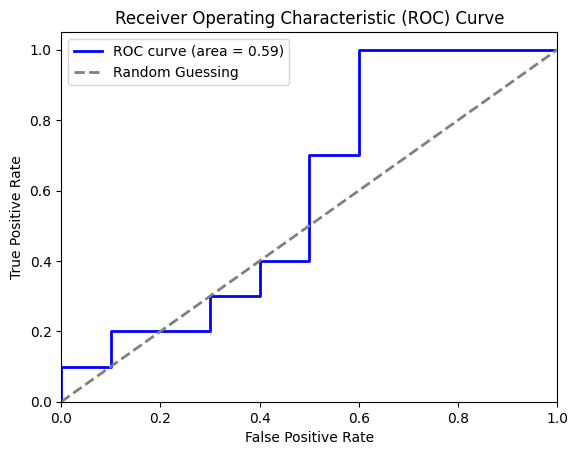

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(best_model)["model_state_dict"])
model.eval()

test_loss = 0
test_correct = 0
test_total = 0
all_target = []
all_prob = []

with torch.no_grad():
    # calculate accuracy and AUROC on test set
    for video, target in tqdm(test_loader, desc="Testing", unit="data"):
            video, target = video.to(device), target.to(device)

            output = model(video)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, pred = torch.max(output, 1)
            test_correct += (pred == target).sum().item()
            test_total += target.size(0)

            probs = F.softmax(output, dim=1)[:,0].cpu().numpy()
            targets = target.cpu().numpy()
            all_prob.extend(probs)
            all_target.extend(targets)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

roc_auc = roc_auc_score(all_target, all_prob)

# print accuracy
print(f"\nTest Loss: {test_loss:.4f}\nTest Accuracy: {test_accuracy:.4f}\nAUROC: {roc_auc:.4f}")

# plot AUROC
fpr, tpr, thresholds = roc_curve(all_target, all_prob, drop_intermediate=False)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guessing')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='upper left')
plt.show()